In [26]:
import sys
from itertools import combinations
from itertools import product
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
sys.path.append(os.path.abspath('../../TMR_to_BF'))
from BF_properties import *

# Average sensitivity calculation

In [27]:
'''
-- To calculate the average sensitivity of a BF (imported from BF_properties)
k: Number of inputs
f: The BF as a a 2^k length string of 0's and 1's
'''
k = 3
f = '10110011'
bf(k, f).avg_sensitivity()

1.25

# Boolean complexity calculation

See the GitHub folder: https://github.com/asamallab/MCBF/tree/main/Boolean_complexity

# Computation of averaged sensitivity for NCFs and TMRs

In [28]:
def IMR_BMR_averaged_sen_calc(k, TMR_type):
    df_TMR = pd.read_csv(f'../input/{TMR_type}_complexity/{TMR_type}_complexity_k{k}.tsv', sep = '\t', dtype={'EF_BF':str})
    df_TMR_no_loop = df_TMR[df_TMR['self_loop'] == 'N'].copy()
    df_TMR_no_loop_unique = df_TMR_no_loop[['EF_BF', 'avg_sen']].drop_duplicates()
    df_TMR_grouped_unique_new = df_TMR_no_loop_unique.copy()
    df_TMR_grouped_unique_new.loc[:, 'overlap_count'] = 1
    final_df = df_TMR_grouped_unique_new.groupby('avg_sen', as_index=False)['overlap_count'].sum()
    weighted_avg_sen = (final_df['avg_sen'] * final_df['overlap_count']).sum() / final_df['overlap_count'].sum()
    return weighted_avg_sen

In [29]:
def NCF_weighted_avg_sen(k):
    df_NCF_rule = pd.read_csv(f'../input/avg_sensitivity_NCFs/NCF_avg_sen_df_k{k}.tsv', sep = '\t', dtype={'all_UFs': str})
    df_NCF_rule['overlap_count'] = 1
    df_NCF_grouped = df_NCF_rule.groupby(['avg_sen'], as_index=False)['overlap_count'].sum()
    weighted_avg_sen_NCF = (df_NCF_grouped['avg_sen'] * df_NCF_grouped['overlap_count']).sum() / df_NCF_grouped['overlap_count'].sum()
    return weighted_avg_sen_NCF

In [30]:
weighted_ave_avg_sen_without_self_loop = {'k':[], 'NCF': [], 'IMR':[], 'BMR': []}
for k in range(1,10):
    weighted_ave_avg_sen_without_self_loop['k'].append(k)
    weighted_ave_avg_sen_without_self_loop['NCF'].append(NCF_weighted_avg_sen(k))
    weighted_ave_avg_sen_without_self_loop['IMR'].append(IMR_BMR_averaged_sen_calc(k, 'IMR'))
    weighted_ave_avg_sen_without_self_loop['BMR'].append(IMR_BMR_averaged_sen_calc(k, 'BMR'))

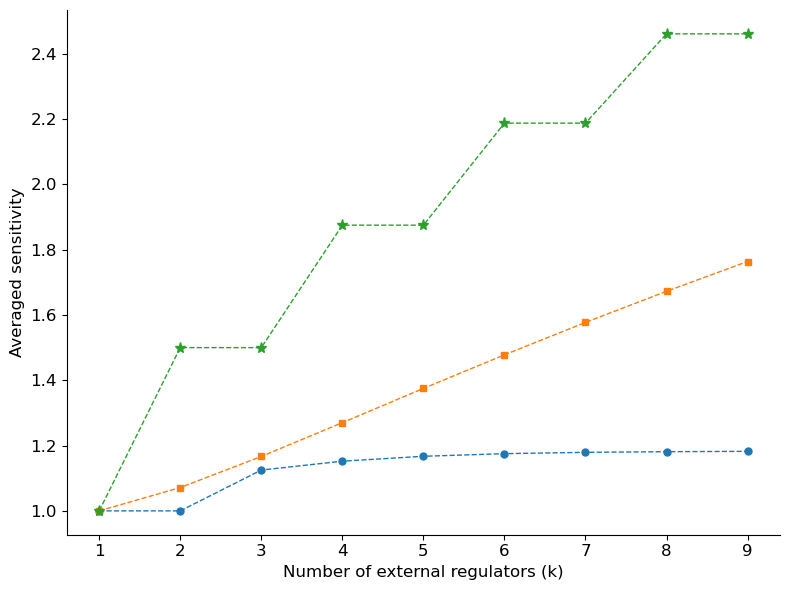

In [31]:
plt.figure(figsize=(8, 6))
k = weighted_ave_avg_sen_without_self_loop['k']
NCF = weighted_ave_avg_sen_without_self_loop['NCF']
IMR = weighted_ave_avg_sen_without_self_loop['IMR']
BMR = weighted_ave_avg_sen_without_self_loop['BMR']


plt.plot(k, NCF, label='NCF', linestyle='--', marker='o', markersize= 5, linewidth=1)
plt.plot(k, BMR, label='BMR', linestyle='--', marker='s', markersize= 5, linewidth=1)
plt.plot(k, IMR, label='IMR', linestyle='--', marker='*', markersize= 8, linewidth=1)


plt.xlabel('Number of external regulators (k)', fontsize = 12)
plt.ylabel('Averaged sensitivity', fontsize = 12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()

plt.show()

# Signwise average sensitivity for TMRs and NCFs

In [32]:
def NCF_avg_sen_df(k):
    df_NCF_rule = pd.read_csv(f'../input/avg_sensitivity_NCFs/NCF_avg_sen_df_k{k}.tsv', sep = '\t', dtype={'all_UFs': str})
    df_NCF_rule['overlap_count'] = 1
    df_NCF_grouped = df_NCF_rule.groupby(['avg_sen'], as_index=False)['overlap_count'].sum()
    return df_NCF_grouped

In [33]:
def IMR_BMR_avg_sen_df(k, TMR_type):
    df_TMR = pd.read_csv(f'../input/{TMR_type}_complexity/{TMR_type}_complexity_k{k}.tsv', sep = '\t', dtype={'EF_BF':str})
    df_TMR_no_loop = df_TMR[df_TMR['self_loop'] == 'N'].copy()
    df_TMR_no_loop.loc[:, 'null_column'] = 0
    df_TMR_grouped = df_TMR_no_loop.groupby(['sign', 'EF_BF', 'avg_sen'], as_index=False)['null_column'].sum()
    df_TMR_grouped_new = df_TMR_grouped.copy()
    df_TMR_grouped_new.loc[:, 'overlap_count'] = 1
    df_TMR_grouped_new_grouped = df_TMR_grouped_new.groupby(['sign', 'avg_sen'], as_index=False)['overlap_count'].sum()
    return df_TMR_grouped_new_grouped

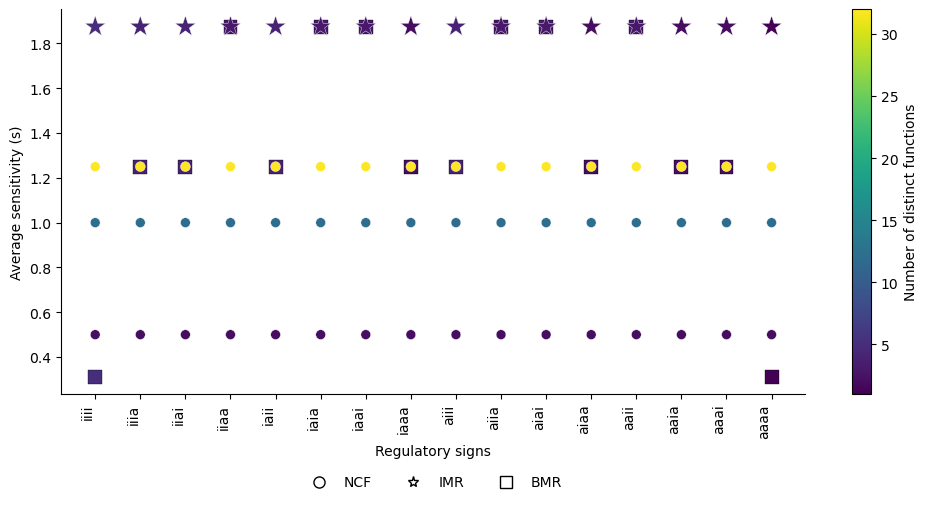

In [34]:
k = 4
all_signs = [list(seq) for seq in product([-1, 1], repeat=k)]
sign_strings = [''.join('i' if num == -1 else 'a' for num in sublist) for sublist in all_signs]
df_avg_sen_NCF = NCF_avg_sen_df(k)
df_avg_sen_IMR = IMR_BMR_avg_sen_df(k, 'IMR')
df_avg_sen_BMR = IMR_BMR_avg_sen_df(k, 'BMR')

vmin = min(df_avg_sen_NCF["overlap_count"].min(), df_avg_sen_IMR["overlap_count"].min(), df_avg_sen_BMR["overlap_count"].min())
vmax = max(df_avg_sen_NCF["overlap_count"].max(), df_avg_sen_IMR["overlap_count"].max(), df_avg_sen_BMR["overlap_count"].max())
norm = plt.Normalize(vmin, vmax)
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(12, 5))

for sign in sign_strings:
    ax.scatter(
        [sign] * len(df_avg_sen_NCF), df_avg_sen_NCF["avg_sen"], 
        c=df_avg_sen_NCF["overlap_count"], cmap=cmap, norm=norm, 
        edgecolors="white", s=50, marker='o', label="NCF", zorder=3,linewidths=0.30
)


ax.scatter(
    df_avg_sen_IMR["sign"], df_avg_sen_IMR["avg_sen"], 
    c=df_avg_sen_IMR["overlap_count"], cmap=cmap, norm=norm, 
    marker="*", edgecolors="white", s=250, label="IMR", zorder=2, linewidths=0.30
)


ax.scatter(
    df_avg_sen_BMR["sign"], df_avg_sen_BMR["avg_sen"], 
    c=df_avg_sen_BMR["overlap_count"], cmap=cmap, norm=norm, 
    marker="s", edgecolors="black", s=100, label="BMR", zorder=1, linewidths=0.25
)



cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label("Number of distinct functions")


ax.set_xlabel("Regulatory signs")
ax.set_ylabel("Average sensitivity (s)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                        markerfacecolor='white', markeredgecolor='black', markersize=8,
                        label="NCF")
star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markerfacecolor='white', markeredgecolor='black', markersize=8,
                          label="IMR")
square = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                        markerfacecolor='white', markeredgecolor='black', markersize=8,
                        label="BMR")


ax.legend(handles=[circle, star, square], loc="lower center", frameon=False, 
          bbox_to_anchor=(0.5, -0.28), ncol=3)


plt.xticks(rotation=90, ha="right")
ax.set_xticks(sign_strings)
plt.gca().set_aspect('auto')

plt.show()

# Computation of averaged Boolean complexities for NCFs and TMRs

In [35]:
def IMR_BMR_averaged_Bool_complx_calc(k, TMR_type):
    df_TMR = pd.read_csv(f'../input/{TMR_type}_complexity/{TMR_type}_complexity_k{k}.tsv', sep = '\t', dtype={'EF_BF':str})
    df_TMR_no_loop = df_TMR[df_TMR['self_loop'] == 'N'].copy()
    df_TMR_no_loop_unique = df_TMR_no_loop[['EF_BF', 'complexity']].drop_duplicates()
    df_TMR_grouped_unique_new = df_TMR_no_loop_unique.copy()
    df_TMR_grouped_unique_new.loc[:, 'overlap_count'] = 1
    final_df = df_TMR_grouped_unique_new.groupby('complexity', as_index=False)['overlap_count'].sum()
    avged_Bool_complx = (final_df['complexity'] * final_df['overlap_count']).sum() / final_df['overlap_count'].sum()
    return avged_Bool_complx

In [36]:
averaged_Bool_complx = {'k':[], 'NCF': [], 'IMR':[], 'BMR': []}
for k in range(1,10):
    averaged_Bool_complx['k'].append(k)
    averaged_Bool_complx['NCF'].append(k)
    averaged_Bool_complx['IMR'].append(IMR_BMR_averaged_Bool_complx_calc(k, 'IMR'))
    averaged_Bool_complx['BMR'].append(IMR_BMR_averaged_Bool_complx_calc(k, 'BMR'))

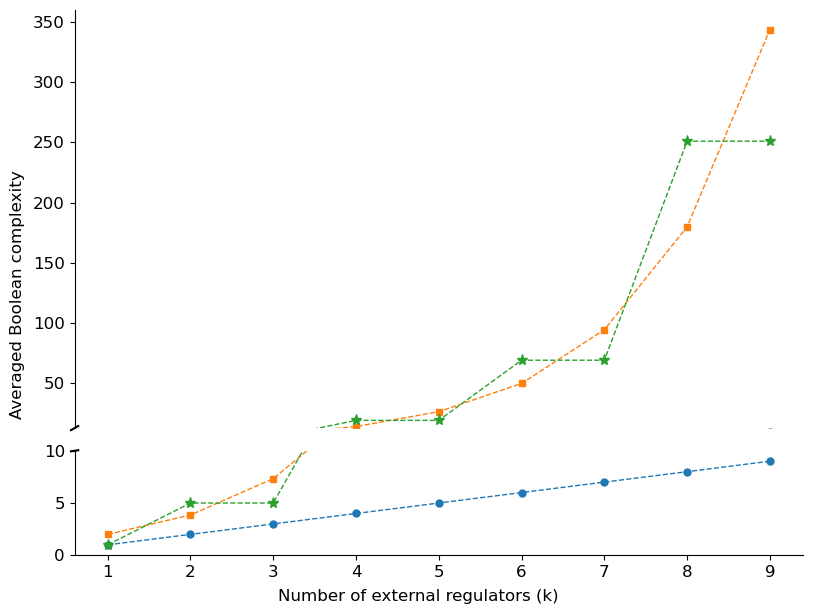

In [37]:
k = averaged_Bool_complx['k']
NCF = averaged_Bool_complx['NCF']
IMR = averaged_Bool_complx['IMR']
BMR = averaged_Bool_complx['BMR']

fig, (ax_high, ax_low) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6),
    gridspec_kw={'height_ratios': [4, 1]}
)


for ax in (ax_low, ax_high):
    ax.plot(k, NCF, label='NCF', linestyle='--', marker='o', markersize=5, linewidth=1)
    ax.plot(k, BMR, label='BMR', linestyle='--', marker='s', markersize=5, linewidth=1)
    ax.plot(k, IMR, label='IMR', linestyle='--', marker='*', markersize=8, linewidth=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


ax_low.set_ylim(0, 10)
ax_high.set_ylim(12.6, 360)


ax_high.spines['bottom'].set_visible(False)
ax_high.tick_params(bottom=False, labelbottom=False)
ax_high.tick_params(axis='y', labelsize=12)
ax_low.tick_params(axis='y', labelsize=12)
ax_low.tick_params(axis='x', labelsize=12)


d = .005
kwargs = dict(transform=ax_low.transAxes, color='k', clip_on=False)
ax_low.plot((-d, +d), (1 - d, 1 + d), **kwargs)
kwargs = dict(transform=ax_high.transAxes, color='k', clip_on=False)
ax_high.plot((-d, +d), (-d, +d), **kwargs)


fig.text(0.5, -0.01, 'Number of external regulators (k)', ha='center', fontsize = 12)
fig.text(-0.01, 0.5, 'Averaged Boolean complexity', va='center', rotation='vertical',fontsize = 12)

plt.tight_layout()
plt.show()

# Signwise Boolean complexities for TMRs and NCFs

In [38]:
def NCF_complexity_df(k):
    df_NCF_rule = pd.read_csv(f'../input/avg_sensitivity_NCFs/NCF_avg_sen_df_k{k}.tsv', sep = '\t')
    df_NCF = pd.DataFrame()
    df_NCF['overlap_count'] = [len(df_NCF_rule)]
    df_NCF['complexity'] = [k]
    return df_NCF

In [39]:
def IMR_BMR_complexity_df(k, TMR_type):
    df_TMR = pd.read_csv(f'../input/{TMR_type}_complexity/{TMR_type}_complexity_k{k}.tsv', sep = '\t', dtype={'EF_BF':str})
    df_TMR_no_loop = df_TMR[df_TMR['self_loop'] == 'N'].copy()
    df_TMR_no_loop.loc[:, 'null_column'] = 0
    df_TMR_grouped = df_TMR_no_loop.groupby(['sign', 'EF_BF', 'complexity'], as_index=False)['null_column'].sum()
    df_TMR_grouped_new = df_TMR_grouped.copy()
    df_TMR_grouped_new.loc[:, 'overlap_count'] = 1
    df_TMR_grouped_new_grouped = df_TMR_grouped_new.groupby(['sign', 'complexity'], as_index=False)['overlap_count'].sum()
    return df_TMR_grouped_new_grouped

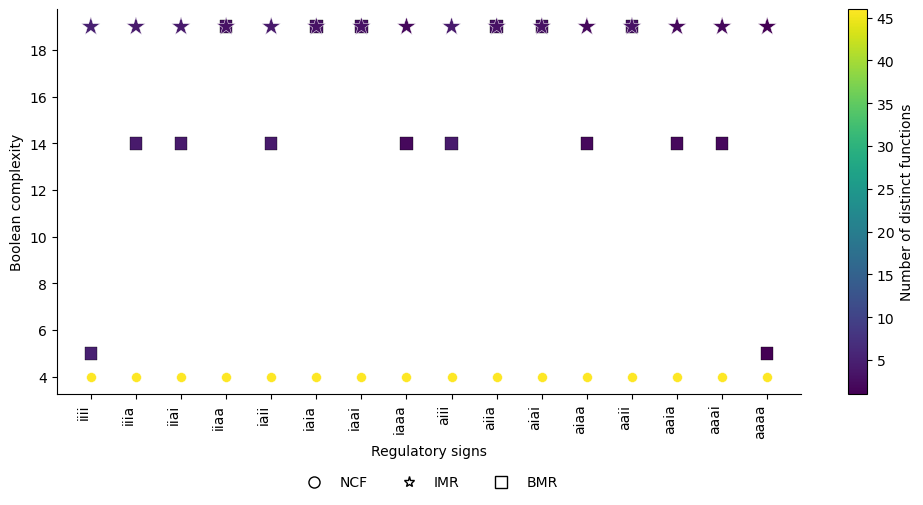

In [40]:
k = 4 
all_signs = [list(seq) for seq in product([-1, 1], repeat=k)]
sign_strings = [''.join('i' if num == -1 else 'a' for num in sublist) for sublist in all_signs]
df_complexity_NCF = NCF_complexity_df(k)
df_complexity_IMR = IMR_BMR_complexity_df(k, 'IMR')
df_complexity_BMR = IMR_BMR_complexity_df(k, 'BMR')

vmin = min(df_complexity_NCF["overlap_count"].min(), df_complexity_IMR["overlap_count"].min(), df_complexity_BMR["overlap_count"].min())
vmax = max(df_complexity_NCF["overlap_count"].max(), df_complexity_IMR["overlap_count"].max(), df_complexity_BMR["overlap_count"].max())
norm = plt.Normalize(vmin, vmax)
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(12, 5))

for sign in sign_strings:
    ax.scatter(
        [sign] * len(df_complexity_NCF), df_complexity_NCF["complexity"], 
        c=df_complexity_NCF["overlap_count"], cmap=cmap, norm=norm, 
        edgecolors="white", s=50, marker='o', label="NCF", zorder=3,linewidths=0.30
    )


ax.scatter(
    df_complexity_IMR["sign"], df_complexity_IMR["complexity"], 
    c=df_complexity_IMR["overlap_count"], cmap=cmap, norm=norm, 
    marker="*", edgecolors="white", s=200, label="IMR", zorder=2, linewidths=0.35
)

ax.scatter(
    df_complexity_BMR["sign"], df_complexity_BMR["complexity"], 
    c=df_complexity_BMR["overlap_count"], cmap=cmap, norm=norm, 
    marker="s", edgecolors="black", s=80, label="BMR", zorder=1, linewidths=0.25
)


cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label("Number of distinct functions")

ax.set_xlabel("Regulatory signs")
ax.set_ylabel("Boolean complexity")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                        markerfacecolor='white', markeredgecolor='black', markersize=8,
                        label="NCF")
star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markerfacecolor='white', markeredgecolor='black', markersize=8,
                          label="IMR")
square = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
                        markerfacecolor='white', markeredgecolor='black', markersize=8,
                        label="BMR")


ax.legend(handles=[circle, star, square], loc="lower center", frameon=False, bbox_to_anchor=(0.5, -0.28), ncol=3)

plt.xticks(rotation=90, ha="right")
ax.set_xticks(sign_strings)
plt.gca().set_aspect('auto')

plt.show()